# Quantum Phase Estimation using pytket Boxes

When constructing circuits for quantum algorithms it is useful to think of higher level operations than just indiviudal quantum gates.

In pytket we can construct circuits using box structures which abstract away the complexity of the underlying circuit.

To demonstrate boxes in pytket we will consider the quantum phase estimation algorithm (QPE). This is an important subroutine in several quantum algorithms including Shor's algorithm and fault-tolerant approaches to quantum chemistry.

## Overview of Phase Estimation

Quantum phase estimation allows us to estimate the eigenvalues of some unitary operator $U$ to some desired precision.

Given that $U$ is unitary its eigenvalues must lie on the unit circle. The following eigenvalue equation holds.

$$
\begin{equation}
U |\psi \rangle = e^{2 \pi i \theta} |\psi\rangle\,, \quad 0 \leq \theta \leq 1
\end{equation}
$$

Here $|\psi \rangle$ is an eigenstate of the operator $U$. In phase estimation we estimate the eigenvalue $e^{2 \pi i \theta}$ by approximating $\theta$. 


The circuit for Quantum phase estimation is itself composed of several subroutines which we can realise as boxes.

![](phase_est.png "Quantum Phase Estimation Circuit")

QPE is generally split up into three stages

1. Firstly we prepare an initial state in one register. In parallel we prepare a uniform superposition state using Hadamard gates on some ancilla qubits. [*] The number of ancilla qubits determines how precisely we can estimate the phase $\theta$.

2. Secondly we apply successive controlled $U$ gates. This has the effect of kicking back phases onto the ancilla qubits according to the eigenvalue quation above.

3. Finally we apply the inverse Quantum Fourier Transform (QFT). This essentially plays the role of destructive interference supressing amplitudes from "undesirable states" and hopefully allowing us to measure a single outcome (or a small number of outcomes) with high probability.


There is some subtlety around the first two points. The initial state used can be an exact eigenstate of $U$ however this may be difficult to prepare if we don't know the eigenvalues of  $U$ in advance. Alternatively we could use an initial state that is a linear combination of eigenstates as phase estimation projects into the eigenspace of $U$.

We also assume that we can implement $U$ with a quantum circuit. In chemistry applications $U$ could be of the form $U=e^{iHt}$ where $H$ is the Hamiltonian of some system of interest. In the cannonical algorithm, the number of controlled unitaries we apply scales exponentially with the number of ancilla qubits. This allows more precision at the expense of a larger quantum circuit. 

## The Quantum Fourier Transform

Before considering the other parts of the QPE algorithm, lets focus on the Quantum Fourier Transfrom (QFT) subroutine.

Mathematically, the QFT has the following action. 

\begin{equation}
QFT : |j\rangle\ \longmapsto \sum_{k=0}^{N - 1} e^{2 \pi ijk/N}|k\rangle, \quad N= 2^k
\end{equation}

This is essentially the Discrete Fourier transform except the input is a quantum state $|j\rangle$.

It is well known that the QFT can be implemented efficently with a quantum circuit

We can build the circuit for the $n$ qubit QFT using $n$ Hadamard gates $\frac{n}{2}$ swap gates and $\frac{n(n-1)}{2}$ controlled unitary rotations $\text{CU1}$.

$$
 \begin{equation}
 CU1(\phi) =
 \begin{pmatrix}
 I & 0 \\
 0 & U1(\phi)
 \end{pmatrix}
 \,, \quad
U1(\phi) =
 \begin{pmatrix}
 1 & 0 \\
 0 & e^{i \phi}
 \end{pmatrix}
 \end{equation}
$$

The circuit for the Quantum Fourier transform on three qubits is the following

![](qft.png "QFT Circuit")

We can build this circuit in pytket by adding gate operations manually

In [1]:
from pytket.circuit import Circuit, OpType

# lets build the QFT for three qubits
qft3_circ = Circuit(3)

qft3_circ.H(0)
qft3_circ.add_gate(OpType.CU1 , [0.5], [1, 0])
qft3_circ.add_gate(OpType.CU1 , [0.25], [2, 0])

qft3_circ.H(1)
qft3_circ.add_gate(OpType.CU1 , [0.5], [2, 1])

qft3_circ.H(2)

qft3_circ.SWAP(0, 2)

[H q[0]; CU1(0.5) q[1], q[0]; CU1(0.25) q[2], q[0]; H q[1]; CU1(0.5) q[2], q[1]; H q[2]; SWAP q[0], q[2]; ]

In [2]:
from pytket.circuit.display import render_circuit_jupyter

render_circuit_jupyter(qft3_circ)

We can generalise the quantum Fourier transform to $n$ qubits by iterating over the qubits as follows

In [3]:
def build_qft_circuit(n_qubits: int) -> Circuit:
    circ = Circuit(n_qubits, name="QFT")
    q_counter = 0
    for j in range(n_qubits):
        circ.H(j)
        q_counter += 1
        for k in range(n_qubits - q_counter):
            circ.add_gate(OpType.CU1, 0.5 ** (k + 1), [k + q_counter, q_counter - 1])

    for i in range(0, n_qubits // 2):
        circ.SWAP(i, n_qubits - i - 1)

    return circ

In [4]:
qft4_circ = build_qft_circuit(4)

render_circuit_jupyter(qft4_circ)

Now that we have the generalised circuit we can wrap it up in a `CircBox` which can then be added to another circuit as a subroutine.

In [5]:
from pytket.circuit import CircBox

qft4_box = CircBox(qft4_circ)

qft_circ = Circuit(4).add_gate(qft4_box, [0, 1, 2, 3])

render_circuit_jupyter(qft_circ)

Note how the `CircBox` inherits the name `QFT` from the underlying circuit.

Recall that in our phase estimation algorithm we need to use the inverse QFT.

$$
\begin{equation}
\text{QFT}^† : \sum_{k=0}^{N - 1} e^{2 \pi ijk/N}|k\rangle \longmapsto |j\rangle\,, \quad N= 2^k
\end{equation}
$$


Now that we have the QFT circuit we can obtain the inverse by using `CircBox.dagger`. We can also verify that this is correct by inspecting the circuit inside with `CircBox.get_circuit()`.

In [6]:
inv_qft4_box = qft4_box.dagger

render_circuit_jupyter(inv_qft4_box.get_circuit())

## The Controlled Unitary Stage

Suppose that we had the following decomposition for $H$ in terms of Pauli strings $P_j$ and complex coefficents $\alpha_j$.

\begin{equation}
H = \sum_j \alpha_j P_j\,, \quad ,\, P_j \in \{I, X, Y, Z\}^{\otimes n}
\end{equation}

In such a case we could synthesise $U$ as a sequence of Pauli gadgets using pytket's `PauliExpBox`. See the [user manual](https://cqcl.github.io/pytket/manual/manual_circuit.html#pauli-exponential-boxes-and-phase-polynommials) for more discussion.

As an example lets consider a Hamiltonian for diatomic hydrogen $H_2$.

In [7]:
from pytket import Qubit
from pytket.pauli import Pauli, QubitPauliString
from pytket.utils import QubitPauliOperator

q = [Qubit(i) for i in range(4)]
iiii = QubitPauliString(q, [Pauli.I] * 4 )
iiiz = QubitPauliString(q, [Pauli.I, Pauli.I, Pauli.I, Pauli.Z] )
iizi = QubitPauliString(q, [Pauli.I, Pauli.I, Pauli.Z, Pauli.I] )
izii = QubitPauliString(q, [Pauli.I, Pauli.Z, Pauli.I, Pauli.I] )
ziii = QubitPauliString(q, [Pauli.Z, Pauli.I, Pauli.I, Pauli.I] )
zizi = QubitPauliString([q[0], q[2]], [Pauli.Z, Pauli.Z])
iziz = QubitPauliString([q[0], q[3]], [Pauli.Z, Pauli.Z])
zzii = QubitPauliString([q[0], q[1]], [Pauli.Z, Pauli.Z])
izzi = QubitPauliString([q[1], q[2]], [Pauli.Z, Pauli.Z])
yxxy = QubitPauliString(q, [Pauli.Y, Pauli.X, Pauli.X, Pauli.Y])
xxyy = QubitPauliString(q, [Pauli.X, Pauli.X, Pauli.Y, Pauli.Y])
yyxx = QubitPauliString(q, [Pauli.Y, Pauli.Y, Pauli.X, Pauli.X])
xyyx = QubitPauliString(q, [Pauli.X, Pauli.Y, Pauli.Y, Pauli.X])
ziiz = QubitPauliString(q, [Pauli.Z, Pauli.I, Pauli.I, Pauli.Z])
iizz = QubitPauliString(q, [Pauli.I, Pauli.I, Pauli.Z, Pauli.Z])

In [8]:
qpo_dict = {QubitPauliString(): -0.0596205827603462, iiiz: 0.175759429183197, 
            iizi: -0.236671176780357, izii: 0.175759429183197,
            iiiz: -0.236671176780357, zizi: 0.122227149362618, iziz: 0.122227149362618,
            zzii: 0.170015464396032, izzi: 0.167144319253372,
            yxxy: 0.0449171698907539, xxyy: -0.0449171698907539, 
            yyxx: -0.0449171698907539, xyyx: 0.0449171698907539,
            ziiz: 0.167144319253372, iizz: 0.175703383319070}

In [9]:
qpo_h2 = QubitPauliOperator(qpo_dict)

In [10]:
from pytket.utils import gen_term_sequence_circuit
from pytket.passes import DecomposeBoxes

h2_circ = gen_term_sequence_circuit(qpo_h2, Circuit(4))
h2_circ.name = "U"

render_circuit_jupyter(h2_circ)

We can create a controlled unitary $U$ with a `QControlBox` with $n$ controls

In [11]:
from pytket.circuit import QControlBox

u_box = CircBox(h2_circ)

In [12]:
controlled_u = QControlBox(u_box, n=1)

In [13]:
test_circ = Circuit(5).add_gate(controlled_u, [0, 1, 2, 3, 4])
render_circuit_jupyter(test_circ)

## Putting it all together

In [44]:
def build_phase_est_circuit(n_measurement_qubits: int,
                            state_prep_circuit: Circuit,
                            unitary_circuit: Circuit) -> Circuit:
    qpe_circ = Circuit()
    n_ancillas = state_prep_circuit.n_qubits
    measurement_register = qpe_circ.add_q_register("m", n_measurement_qubits)
    state_prep_register = qpe_circ.add_q_register("p", n_ancillas)
    c_reg = qpe_circ.add_c_register("c", n_measurement_qubits)
    
    state_prep_qubits = list(state_prep_register)
    measurement_qubits = list(measurement_register)
    
    qpe_circ.add_circuit(state_prep_circuit, state_prep_qubits)
    
    unitary_circuit.name = "U"
    u_box = CircBox(unitary_circuit)
    controlled_u = QControlBox(u_box, 1)
    
    for m_qubit in measurement_qubits:
        qpe_circ.H(m_qubit)
        
    for m_qubit in range(n_measurement_qubits):
        control_index = n_measurement_qubits - m_qubit - 1
        control_qubit = [measurement_register[control_index]]
        for _ in range(2**m_qubit):
                qpe_circ.add_qcontrolbox(
                    controlled_u, control_qubit + state_prep_qubits
                )
        
    qft_box = CircBox(build_qft_circuit(n_measurement_qubits))
    inverse_qft_box = qft_box.dagger
    
    qpe_circ.add_circbox(inverse_qft_box, measurement_qubits)
    
    qpe_circ.measure_register(measurement_register, "c")
    
    return qpe_circ

## Phase Estimation with a Trivial Eigenstate

Lets test our circuit construction by preparing a trivial $|1\rangle $eigenstate of the $\text{U1}$ gate. We can then see if our phase estimation circuit returns the expected eigenvalue.

$$
\begin{equation}
U1(\phi)|1\rangle = e^{i\phi} = e^{2 \pi i \theta} \implies \theta = \frac{\phi}{2}
\end{equation}
$$

So we expect that our ideal phase $\theta$ will be half the input angle $\phi$ to our $U1$ gate.

In [51]:
state_prep_circuit = Circuit(1).X(0)

input_angle = 0.73

unitary_circuit = Circuit(1).add_gate(OpType.U1, [input_angle], [0])

In [52]:
qpe_circ_trivial = build_phase_est_circuit(4, state_prep_circuit=state_prep_circuit, unitary_circuit=unitary_circuit)

In [59]:
render_circuit_jupyter(qpe_circ_trivial)

Lets use the noiseless `AerBackend` simulator to run our phase estimation circuit.

In [54]:
from pytket.extensions.qiskit import AerBackend

backend = AerBackend()

compiled_circ = backend.get_compiled_circuit(qpe_circ_trivial)


n_shots = 1000
result = backend.run_circuit(compiled_circ, n_shots)

print(result.get_counts())

Counter({(0, 1, 1, 0): 934, (0, 1, 0, 1): 32, (0, 1, 1, 1): 8, (1, 0, 0, 0): 5, (0, 0, 1, 0): 4, (0, 0, 0, 0): 3, (0, 0, 1, 1): 3, (0, 0, 0, 1): 2, (0, 1, 0, 0): 2, (1, 0, 0, 1): 2, (1, 1, 0, 1): 2, (1, 0, 1, 0): 1, (1, 0, 1, 1): 1, (1, 1, 0, 0): 1})


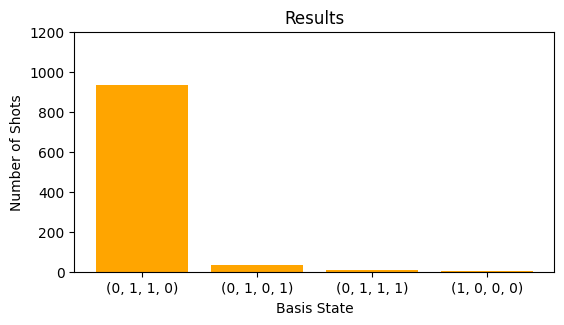

In [56]:
from plotting import plot_qpe_results

plot_qpe_results(result, y_limit=1.2*n_shots)

As expected we see one outcome with high probability. Lets now extract our approximation of $\theta$ from our output bitstrings.

suppose the $j$ is an integer representation of our most commonly measured bitstring.

$$
\begin{equation}
\theta_{estimate} = \frac{j}{N}
\end{equation}
$$

Here $N = 2 ^n$ where $n$ is the number of measurement qubits.

In [20]:
from pytket.backends.backendresult import BackendResult

def single_phase_from_backendresult(result: BackendResult) -> float:
    
    # Extract most common measurement outcome
    basis_state = result.get_counts().most_common()[0][0] 
    bitstring = "".join([str(bit) for bit in basis_state])
    
    # Calculate theta
    n_measurement_qubits = len(bitstring)
    phase_estimate = int(bitstring, 2) / (2**n_measurement_qubits)
    
    return phase_estimate

In [21]:
theta = single_phase_from_backendresult(result)

In [58]:
print(theta)

0.375


Our output is close to half our input angle $\phi$ as expected. Lets calculate our error.

In [23]:
error = round(abs(input_angle - (2*theta)), 5) # 
print(error)

0.0247


## State Preparation

In [24]:
import numpy as np
import scipy

In [25]:
h2_matrix = qpo_h2.to_sparse_matrix().todense()

In [26]:
eigenvalues, eigenvectors = scipy.sparse.linalg.eigs(h2_matrix, k=15)

/Users/callum/.pyenv/versions/3.9.1/lib/python3.9/site-packages/scipy/sparse/linalg/_eigen/arpack/arpack.py:1265: RuntimeWarning: k >= N - 1 for N * N square matrix. Attempting to use scipy.linalg.eig instead.
  warnings.warn("k >= N - 1 for N * N square matrix. "


In [27]:
eigenvectors[0].shape

(16,)

In [28]:
ground_state_array = eigenvectors[0]

In [29]:
from pytket.circuit import StatePreparationBox

ground_state_prep_box = StatePreparationBox(ground_state_array)

In [30]:
h2_state_prep_circuit = Circuit(4).add_gate(ground_state_prep_box, [0, 1, 2, 3])

In [31]:
from pytket.utils import gen_term_sequence_circuit

In [32]:
ham_circ = gen_term_sequence_circuit(qpo_h2, Circuit(4))

from pytket.passes import DecomposeBoxes

In [33]:
DecomposeBoxes().apply(ham_circ)

True

In [34]:
render_circuit_jupyter(ham_circ)

In [35]:
h2_qpe_circuit = build_phase_est_circuit(4, state_prep_circuit=h2_state_prep_circuit, unitary_circuit=ham_circ)

In [36]:
render_circuit_jupyter(h2_qpe_circuit)

In [37]:
from pytket.extensions.qiskit import AerBackend

backend = AerBackend()

compiled_circ2 = backend.get_compiled_circuit(h2_qpe_circuit)


n_shots = 1000
result = backend.run_circuit(compiled_circ2, n_shots)

print(result.get_counts())

Counter({(0, 0, 1, 0): 709, (0, 0, 1, 1): 151, (0, 1, 0, 0): 40, (0, 0, 0, 1): 38, (0, 0, 0, 0): 15, (0, 1, 0, 1): 8, (1, 1, 1, 1): 8, (1, 1, 0, 0): 6, (1, 0, 0, 0): 5, (1, 1, 1, 0): 5, (0, 1, 1, 1): 4, (0, 1, 1, 0): 3, (1, 0, 0, 1): 3, (1, 0, 1, 0): 2, (1, 1, 0, 1): 2, (1, 0, 1, 1): 1})


In [38]:
compiled_circ2.n_gates

7600

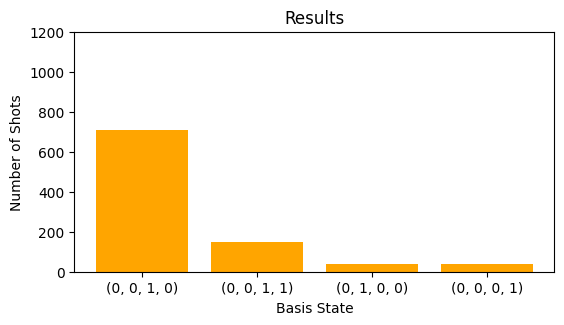

In [39]:
plot_qpe_results(result, y_limit=1.2*n_shots)

In [40]:
eigenvalues[0]

(0.058062885759544235+0j)

In [41]:
phase = single_phase_from_backendresult(result)

In [42]:
def phase_to_eigenvalue(phase: float) -> float:
    
    return np.e ** (2 * 1j * phase)

In [43]:
phase_to_eigenvalue(phase)

(0.9689124217106447+0.24740395925452294j)